Using device: cuda
L shape: torch.Size([10000, 10000]), L device: cuda:0


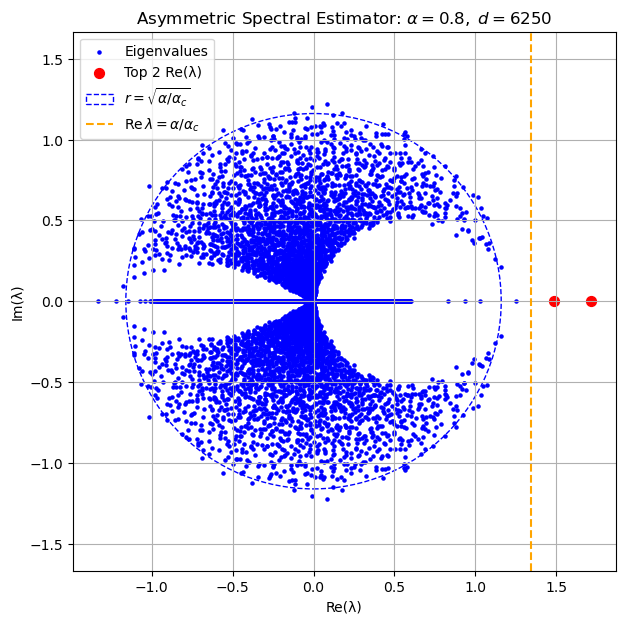

In [4]:
import os
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import kv as besselk


# 固定随机种子（可复现性）
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(42)

# 配置参数
n = 5000  # 样本数
p = 2      # 子空间维度
alpha = 0.8
alpha_c = 0.59375
d = int(n / alpha)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Step 1: 生成输入矩阵 X ∈ ℝ^{n × d}
X = torch.randn(n, d, device=device) / np.sqrt(d)

# Step 2: 构造信号子空间 W* 和观测 Z = X W*
W_star = torch.randn(d, p, device=device)
Z = X @ W_star
z1, z2 = Z[:, 0], Z[:, 1]
y = z1 * z2  # link function: y = z1 * z2

# Step 3: 计算预处理函数 G(y) ∈ ℝ^{n × p × p}
y_cpu = y.detach().cpu().numpy()
abs_y = np.abs(y_cpu)
K1 = besselk(1, abs_y)
K0 = besselk(0, abs_y)
lambda_y = abs_y * (K1 / K0) - 1
lambda_y[np.isnan(lambda_y)] = 0  # 数值稳定处理

# 构造 G(y): 每个样本一个 2x2 对称矩阵
G_y_np = np.zeros((n, p, p), dtype=np.float32)
G_y_np[:, 0, 0] = lambda_y
G_y_np[:, 1, 1] = lambda_y
G_y_np[:, 0, 1] = y_cpu
G_y_np[:, 1, 0] = y_cpu
G_y = torch.tensor(G_y_np, device=device)

# Step 4: 构造非对称谱矩阵 L ∈ ℝ^{np × np}
XXT = X @ X.T  # shape: (n, n)
XXT.fill_diagonal_(0.0)  # 去掉主对角线

# 构造谱矩阵 L 的 (iμ, jν) 元素
A = XXT[:, :, None, None]            # shape: (n, n, 1, 1)
G_broadcast = G_y[None, :, :, :]     # shape: (1, n, p, p)
L_blocks = A * G_broadcast           # shape: (n, n, p, p)
L = L_blocks.permute(0, 2, 1, 3).reshape(n * p, n * p)  # shape: (np, np)
print(f"L shape: {L.shape}, L device: {L.device}")

# Step 5: 计算特征值（在 GPU 上）并绘图
eigvals = torch.linalg.eigvals(L)
eigvals_np = eigvals.detach().cpu().numpy()
eigvals_real = eigvals_np.real

# 获取最大两个实部的特征值索引和特征值
top2_idx = np.argsort(eigvals_real)[-2:]
top2_vals = eigvals_np[top2_idx]

# 可视化谱图
plt.figure(figsize=(7, 7))
plt.scatter(eigvals_np.real, eigvals_np.imag, s=5, color='blue', label='Eigenvalues')
plt.scatter(top2_vals.real, top2_vals.imag, color='red', s=50, label='Top 2 Re(λ)')

# 理论谱圆半径和跳跃阈值
r = np.sqrt(alpha / alpha_c)
thresh = alpha / alpha_c

circle = plt.Circle((0, 0), r, color='blue', fill=False, linestyle='--',
                    label=rf'$r = \sqrt{{\alpha / \alpha_c}}$')
plt.gca().add_artist(circle)
plt.axvline(x=thresh, color='orange', linestyle='--',
            label=rf'$\mathrm{{Re}}\,\lambda = \alpha / \alpha_c$')

# 图形设置
plt.xlabel('Re(λ)')
plt.ylabel('Im(λ)')
plt.title(rf'Asymmetric Spectral Estimator: $\alpha = {alpha},\ d = {d}$')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()


Using device: cuda
Overlap of top-1 Re(λ) eigenvector with true signal subspace: 26.0751
Overlap of top-2 Re(λ) eigenvector with true signal subspace: 288.3826


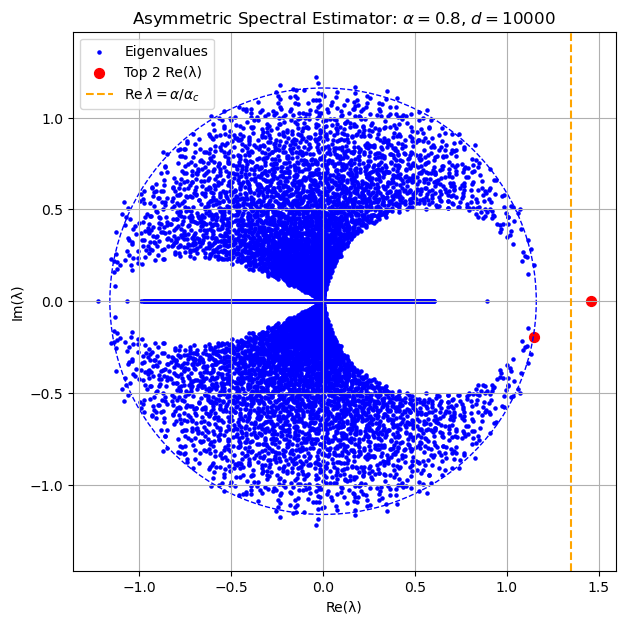

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import kv as besselk

# 固定随机种子（可复现性）
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# 参数配置
n = 8000
p = 2
alpha = 0.8
alpha_c = 0.59375
d = int(n / alpha)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Step 1: 生成输入矩阵 X ∈ ℝ^{n × d}
X = torch.randn(n, d, device=device) / np.sqrt(d)

# Step 2: 构造信号子空间 W* 和观测 Z = X W*
W_star = torch.randn(d, p, device=device)
Z = X @ W_star
z1, z2 = Z[:, 0], Z[:, 1]
y = z1 * z2  # 非线性响应函数

# Step 3: 构造 G(y) ∈ ℝ^{n × p × p}
y_cpu = y.detach().cpu().numpy()
abs_y = np.abs(y_cpu)
K1, K0 = besselk(1, abs_y), besselk(0, abs_y)
lambda_y = abs_y * (K1 / K0) - 1
lambda_y[np.isnan(lambda_y)] = 0  # 数值稳定

G_y_np = np.zeros((n, p, p), dtype=np.float32)
G_y_np[:, 0, 0] = lambda_y
G_y_np[:, 1, 1] = lambda_y
G_y_np[:, 0, 1] = y_cpu
G_y_np[:, 1, 0] = y_cpu
G_y = torch.tensor(G_y_np, device=device)

# Step 4: 构造谱矩阵 L ∈ ℝ^{np × np}
XXT = X @ X.T
XXT.fill_diagonal_(0.0)
A = XXT[:, :, None, None]               # shape: (n, n, 1, 1)
G_broadcast = G_y[None, :, :, :]        # shape: (1, n, p, p)
L_blocks = A * G_broadcast              # shape: (n, n, p, p)
L = L_blocks.permute(0, 2, 1, 3).reshape(n * p, n * p)

# Step 5: 特征分解（在GPU上）
eigvals, eigvecs = torch.linalg.eig(L)  # eigvecs: [np × np]
eigvals = eigvals.detach().cpu().numpy()
eigvecs = eigvecs.detach().cpu().numpy()
eigvals_real = eigvals.real

# Step 6: 提取前两个跳出主特征向量
top2_idx = np.argsort(eigvals_real)[-2:]

for i, idx in enumerate(top2_idx):
    v = eigvecs[:, idx].real  # shape: (n*p,)
    V = v.reshape(n, p)       # shape: (n, p)
    
    # 单位化（防止 overlap 值爆炸）
    V_tensor = torch.tensor(V, dtype=torch.float32, device=device)
    V_proj = X.T @ V_tensor   # shape: (d, p)
    V_proj = V_proj / torch.norm(V_proj)  # 单位化
    inner = V_proj.T @ W_star  # shape: (p, p)
    
    overlap = torch.sum(torch.abs(inner) ** 2).item()
    print(f"Overlap of top-{i+1} Re(λ) eigenvector with true signal subspace: {overlap:.4f}")

# Step 7: 可视化谱图
plt.figure(figsize=(7, 7))
plt.scatter(eigvals.real, eigvals.imag, s=5, color='blue', label='Eigenvalues')
plt.scatter(eigvals[top2_idx].real, eigvals[top2_idx].imag, color='red', s=50, label='Top 2 Re(λ)')
r = np.sqrt(alpha / alpha_c)
plt.gca().add_artist(plt.Circle((0, 0), r, color='blue', fill=False, linestyle='--'))
plt.axvline(x=alpha / alpha_c, color='orange', linestyle='--', label=rf'$\mathrm{{Re}}\,\lambda = \alpha / \alpha_c$')
plt.xlabel('Re(λ)')
plt.ylabel('Im(λ)')
plt.title(rf'Asymmetric Spectral Estimator: $\alpha = {alpha}$, $d = {d}$')
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.show()
